# Daily Return Forcaster

## Environment Setup

In [ ]:
# Create conda enviorment for model
"""
! conda create --name MM3000n
! conda activate MM3000
! conda install pandas
! conda install scikit-learn
! conda install -c conda-forge yfinance
! conda install -c anaconda pandas-datareader
! conda install jupyter
! conda install matplotlib
! conda install -c conda-forge xgboost
! conda install seaborn
"""

In [29]:
from pandas_datareader import data as pdr
from datetime import date, timedelta
import yfinance as yf
import pandas as pd
from importlib import reload # for reloading helper functions after changes
import matplotlib.pyplot as plt
import helper_functions as helper
from random import randint

## Change Ticker Symbol to Desired Stock with start and end dates

In [ ]:
ticker_symbol = 'GOOGL'
start_date = "2015-01-01"
end_date = "2023-04-01"

## Retrieve Data

In [30]:
yf.pdr_override()
yesterday = date.today() - timedelta(days=1) #end date set to yesterday because todays data my not be in
data = pdr.get_data_yahoo(ticker_symbol, start=start_date, end=end_date)
data.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2076 entries, 2015-01-02 to 2023-03-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2076 non-null   float64
 1   High       2076 non-null   float64
 2   Low        2076 non-null   float64
 3   Close      2076 non-null   float64
 4   Adj Close  2076 non-null   float64
 5   Volume     2076 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 113.5 KB


In [31]:
data['daily_ret'] = 100.0 * ((data['Adj Close'] / data['Adj Close'].shift(1)) - 1)
helper.get_set_sma(data)
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
daily_ret    0
sma_7        0
sma_30       0
sma_50       0
dtype: int64

In [32]:
data

,Open,High,Low,Close,Adj Close,Volume,daily_ret,sma_7,sma_30,sma_50
Date,,,,,,,,,,
2015-03-16,30.969999,31.237499,30.717501,31.237499,28.186207,143497200,1.100422,28.148501,28.338000,26.946953
2015-03-17,31.475000,31.830000,31.412500,31.760000,28.657665,204092400,1.672657,28.162680,28.404744,27.028792
2015-03-18,31.750000,32.290001,31.592501,32.117500,28.980249,261083600,1.125647,28.205541,28.482091,27.130924
2015-03-19,32.187500,32.312500,31.850000,31.875000,28.761433,183238000,-0.755055,28.301895,28.545328,27.228635
2015-03-20,32.062500,32.099998,31.290001,31.475000,28.400505,274780400,-1.254901,28.419841,28.590144,27.312432
...,...,...,...,...,...,...,...,...,...,...
2023-03-27,159.940002,160.770004,157.869995,158.279999,158.279999,52390300,-1.229330,158.138569,152.532667,149.289207
2023-03-28,157.970001,158.490005,155.979996,157.649994,157.649994,45992200,-0.398032,158.517140,152.659333,149.751116
2023-03-29,159.369995,161.050003,159.350006,160.770004,160.770004,51305700,1.979074,158.998570,152.911667,150.251861


In [33]:
features_to_drop = ['Open', 'High', 'Low', 'Close', 'sma_30', 'sma_50']
data_trimmed = data.drop(features_to_drop, axis=1)
data_trimmed

,Adj Close,Volume,daily_ret,sma_7
Date,,,,
2015-03-16,28.186207,143497200,1.100422,28.148501
2015-03-17,28.657665,204092400,1.672657,28.162680
2015-03-18,28.980249,261083600,1.125647,28.205541
2015-03-19,28.761433,183238000,-0.755055,28.301895
2015-03-20,28.400505,274780400,-1.254901,28.419841
...,...,...,...,...
2023-03-27,158.279999,52390300,-1.229330,158.138569
2023-03-28,157.649994,45992200,-0.398032,158.517140
2023-03-29,160.770004,51305700,1.979074,158.998570


In [34]:
number_of_days = int(data_trimmed.shape[0])
data_split = list()
data_split.append(data_trimmed[0:int(number_of_days/3)]) 
data_split.append(data_trimmed[int(number_of_days/3):2*int(number_of_days/3)])
data_split.append(data_trimmed[2*int(number_of_days/3):number_of_days])


data_target1 = data_split[0]['daily_ret'].drop(data_split[0].head(5).index)
data_split[0] = helper.series_to_supervised(data_split[0],5,0)
data_split[0]['target'] = data_target1

data_target1 = data_split[1]['daily_ret'].drop(data_split[1].head(5).index)
data_split[1] = helper.series_to_supervised(data_split[1],5,0)
data_split[1]['target'] = data_target1

data_target1 = data_split[2]['daily_ret'].drop(data_split[2].head(5).index)
data_split[2] = helper.series_to_supervised(data_split[2],5,0)
data_split[2]['target'] = data_target1

2017-10-04 00:00:00 to  2017-11-14 00:00:00
Mean Absolute error: 1.088


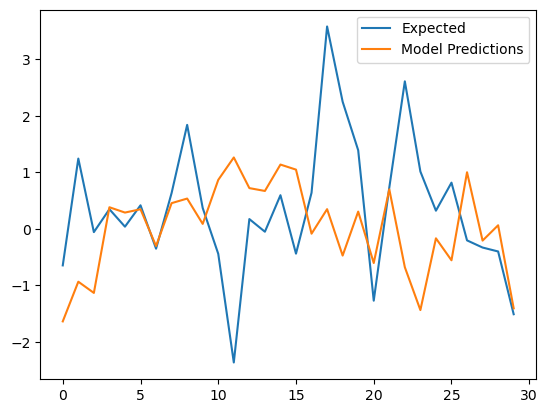

2020-06-11 00:00:00 to  2020-07-23 00:00:00
Mean Absolute error: 1.956


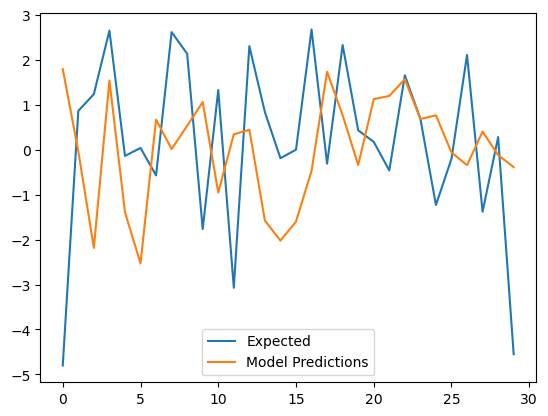

2023-02-17 00:00:00 to  2023-03-31 00:00:00
Mean Absolute error: 1.516


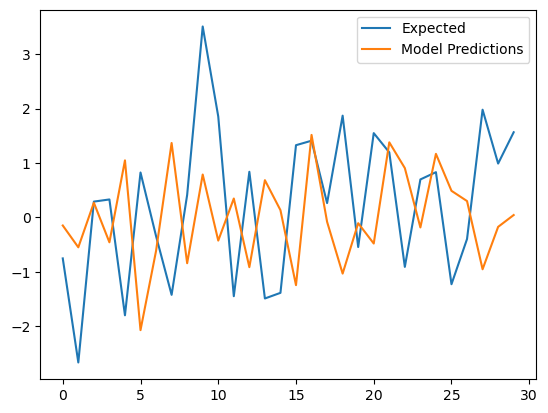

In [35]:
reload(helper)
mae = [None]*3
y = [None]*3
ypred = [None]*3
for i in range(3):
    mae[i], y[i], ypred[i] = helper.walk_forward_validation(data_split[i].values,30)
    print(f'{data_split[i].index[-30]} to  {data_split[i].index[-1]}')
    print(f"Mean Absolute error: {mae[i]:.3f}")
    plt.plot(y[i], label='Expected')
    plt.plot(ypred[i], label='Model Predictions')
    plt.legend()
    plt.show()

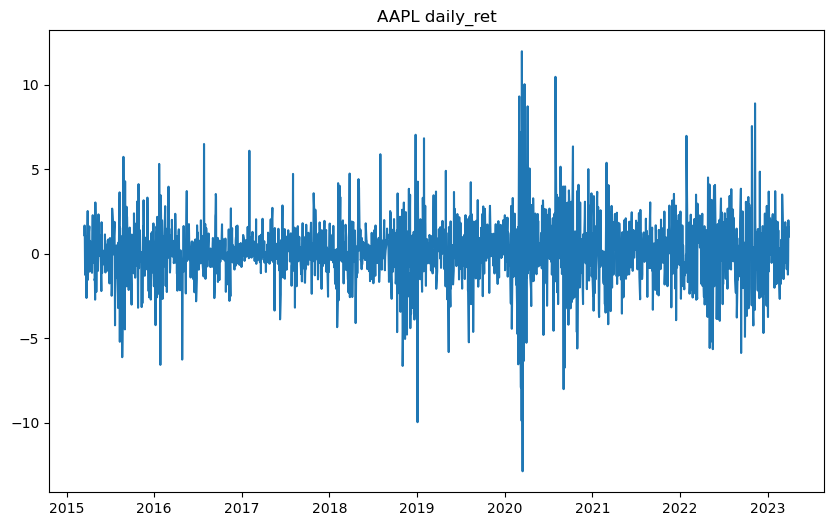

In [36]:
#Display Adjusted close data
plt.figure(figsize=(10,6))
plt.plot(data.index, data["daily_ret"])
plt.title(f"{ticker_symbol} daily_ret")
plt.show()

In [38]:
#data is the previous day and befores lag values trying to predict todays values
#so to predict tomorrow we copy today on to the end of the data set then run the model for the last day 
#to continue making predictions place your prediction in the last rows target then repeat above steps
predictions = list()

full_data = data

#full_data = data_split[2]
#data_target = full_data['Adj Close'].drop(full_data.head(5).index)
#full_data = helper.series_to_supervised(full_data,5,0)
#full_data['target'] = data_target

#add next day
full_data = full_data.append(full_data.iloc[-1])

for i in range(5):
    data_target = full_data['daily_ret'].drop(full_data.head(5).index)
    pred_data = helper.series_to_supervised(full_data,5,0)
    pred_data['target'] = data_target
    mae, y, ypred = helper.walk_forward_validation(pred_data.values,1)
    predictions.append(ypred[-1])
    full_data = full_data.append(full_data.iloc[-1])
    full_data['daily_ret'].iloc[-1] = ypred[-1]
    

print(predictions)


C:\Users\darri\AppData\Local\Temp\ipykernel_30320\4083583038.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])
C:\Users\darri\AppData\Local\Temp\ipykernel_30320\4083583038.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])
C:\Users\darri\AppData\Local\Temp\ipykernel_30320\4083583038.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])
C:\Users\darri\AppData\Local\Temp\ipykernel_30320\4083583038.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.il

[0.25079563, 0.75764626, -0.5114419, -0.012779127, 0.4180035]


C:\Users\darri\AppData\Local\Temp\ipykernel_30320\4083583038.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = full_data.append(full_data.iloc[-1])


In [39]:
print(predictions)

[0.25079563, 0.75764626, -0.5114419, -0.012779127, 0.4180035]


In [42]:
final = pdr.get_data_yahoo(ticker_symbol, start=end_date, end=yesterday)
final = final.head(5)
final['daily_ret Pred'] = ''
for i in range(len(predictions)):
    final['daily_ret Pred'] = predictions
final['daily_ret'] = 100.0 * ((final['Adj Close'] / final['Adj Close'].shift(1)) - 1)
final = final[['daily_ret','daily_ret Pred']]
final

[*********************100%***********************]  1 of 1 completed


C:\Users\darri\AppData\Local\Temp\ipykernel_30320\3040925791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['daily_ret Pred'] = ''
C:\Users\darri\AppData\Local\Temp\ipykernel_30320\3040925791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['daily_ret Pred'] = predictions
C:\Users\darri\AppData\Local\Temp\ipykernel_30320\3040925791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,daily_ret,daily_ret Pred
Date,,
2023-04-03,NaN,0.250796
2023-04-04,-0.324964,0.757646
2023-04-05,-1.129029,-0.511442
2023-04-06,0.549590,-0.012779
2023-04-10,-1.597234,0.418003
